# Importing Libraries

In [1]:
import os
import seaborn as sns
import pylab as plt
import numpy as np 
import pandas as pd
import tensorflow

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from keras_applications import inception_v3, nasnet, vgg19, xception, mobilenet_v2
from keras_applications.imagenet_utils import preprocess_input

from IPython import InteractiveShell
from IPython.display import Image
%matplotlib inline

import warnings as wrn
wrn.filterwarnings('ignore')

/home/shushrut/anaconda3/envs/tfg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shushrut/anaconda3/envs/tfg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shushrut/anaconda3/envs/tfg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shushrut/anaconda3/envs/tfg/lib/python3.7/s

# Importing data

In [2]:
train_dir = "train"
test_dir  = "test"
train_df = pd.read_csv('train.csv')

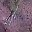

In [3]:
Image(os.path.join(train_dir, train_df.iloc[8, 0]),
      width = 200, height = 200
     )

In [4]:
print("dataset has {} rows and {} columns".format(train_df.shape[0], train_df.shape[1]))

dataset has 17500 rows and 2 columns


# Data preparation
     

    Read the picture files
    Decode JPEG content to RGB pixels
    Convert this into floating tensors
    Rescale pixel values (between 0 to 255) to [0,1] interval.



In [5]:
datagen = ImageDataGenerator(rescale=1./255)

In [6]:
batch_size = 16



###  flow_from_dataframe Method

This method is useful when the images are clustered in only one folder. To put in other words images from different class/labels reside in only one folder. Generally, with such kind of data, some text files containing information on class and other parameters are provided. In this case, we will create a dataframe using pandas and text files provided, and create a meaningful dataframe with columns having file name (only the file names, not the path) and other classes to be used by the model. For this method, arguments to be used are:

    dataframe value : Dataframe having meaningful data (file name, class columns are a must)
    directory value : The path to the parent directory containing all images.
    x_col value : which will be the name of column(in dataframe) having file names
    y_col value : which will be the name of column(in dataframe) having class/label



In [7]:
# The x_col and y_col parameters of flow_from_dataframe accept
# string input,
# so we convert y_col value (has_cactus (int)) to string

train_df.has_cactus = train_df.has_cactus.astype(str)

In [8]:
#use first 15000 for training and remaining for validation
train_gen = datagen.flow_from_dataframe(dataframe = train_df[:15001], 
                                        directory = train_dir,
                                        x_col = 'id',
                                        y_col = 'has_cactus',
                                        class_mode = 'binary',
                                        batch_size = batch_size,
                                        target_size = (32,32)
                                       )

Found 15001 validated image filenames belonging to 2 classes.


In [9]:
val_gen = datagen.flow_from_dataframe(dataframe = train_df[15001:],
                                      directory = train_dir,
                                      x_col = 'id',
                                      y_col = 'has_cactus',
                                      class_mode = 'binary',
                                      batch_size = batch_size,
                                      target_size = (32,32)
                                     )

Found 2499 validated image filenames belonging to 2 classes.


### Modeling

In [10]:
dropout_dense_layer = 0.6

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(1))
model.add(Activation('sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model.compile(optimizer = Adam(lr = .0007),
              loss = 'binary_crossentropy',
              metrics = ['accuracy']
             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [13]:
his = model.fit(train_gen,
                epochs = 20,
                validation_data = val_gen,
                validation_steps = 2,
                callbacks=callbacks,
                )

Epoch 1/20
938/938 [==============================] - 77s 82ms/step - loss: 0.1912 - acc: 0.9287 - val_loss: 0.0631 - val_acc: 0.9375
Epoch 2/20
938/938 [==============================] - 72s 77ms/step - loss: 0.1022 - acc: 0.9665 - val_loss: 0.1593 - val_acc: 0.9375
Epoch 3/20
938/938 [==============================] - 72s 77ms/step - loss: 0.0768 - acc: 0.9751 - val_loss: 0.1834 - val_acc: 0.9375
Epoch 4/20
938/938 [==============================] - 72s 77ms/step - loss: 0.0625 - acc: 0.9803 - val_loss: 0.0635 - val_acc: 0.9688
Epoch 5/20
938/938 [==============================] - 74s 79ms/step - loss: 0.0518 - acc: 0.9836 - val_loss: 0.0404 - val_acc: 0.9688
Epoch 6/20
938/938 [==============================] - 74s 78ms/step - loss: 0.0540 - acc: 0.9839 - val_loss: 0.0171 - val_acc: 1.0000
Epoch 7/20
938/938 [==============================] - 75s 80ms/step - loss: 0.0361 - acc: 0.9903 - val_loss: 0.0637 - val_acc: 0.9688
Epoch 8/20
938/938 [==============================] - 72s 77ms

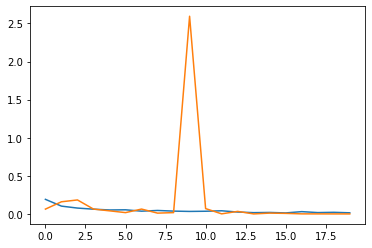

In [14]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.show()

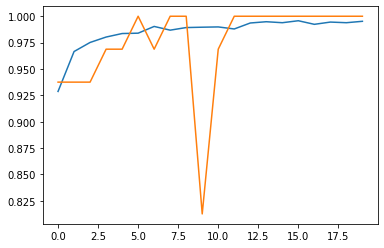

In [15]:
plt.plot(his.history['acc'])
plt.plot(his.history['val_acc'])
plt.show()